In [1]:
import math
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from sklearn.externals.joblib import dump
#from sklearn.externals.joblib import load
#from sklearn.feature_selection import RFE

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Create one random seed number for reproducible results
seedNum = 888

# Libraries for neural network
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

### Reading data

In [2]:
#[kannan: directly reading the data, later change the pipeline to preprocessed, feature engineered data]
#inputFile = '../data/input/OnlineNewsPopularity.csv' #Error tokenizing data. C error: Expected 1 fields in line 6, saw 3
#df = pd.read_csv(inputFile)
inputFile = '../data/input/OnlineNewsPopularity.xlsx'
df = pd.read_excel(inputFile)
df.columns = df.columns.str.replace(' ','')
print(df.shape)
df.head()

(7795, 20)


,Id,url,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,shares
0,1,http://mashable.com/2014/09/01/americans-held-...,10,261,0.661355,1.0,0.787500,7,3,1,1,4.873563,7,0,0,0,0,0,1,1100
1,2,http://mashable.com/2014/09/01/apple-visa-mast...,7,1791,0.370242,1.0,0.535038,74,3,50,0,4.554439,8,0,0,0,0,0,0,1100
2,3,http://mashable.com/2014/09/01/aussie-football...,7,503,0.524291,1.0,0.704918,3,3,1,0,5.003976,5,0,0,0,0,0,1,1000
3,4,http://mashable.com/2014/09/01/australia-gover...,10,526,0.536204,1.0,0.654867,17,1,1,0,4.998099,9,0,0,0,0,0,1,822
4,5,http://mashable.com/2014/09/01/australia-jane-...,13,237,0.619048,1.0,0.807143,5,3,1,0,5.046414,9,0,0,0,0,0,1,841


In [3]:
# Dropping useless attributes
df.drop('url', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [4]:
# variables for total columns, total input attributes, target column index and renaming target variable
totCol = len(df.columns)
totAttr = totCol-1
targetCol = totCol #last column
df.rename(columns={'shares': 'targetVar'}, inplace=True)

In [5]:
df['targetVar'].value_counts()

1100     505
1200     431
1300     348
1400     347
1000     280
        ... 
162        1
178        1
20700      1
37100      1
12400      1
Name: targetVar, Length: 917, dtype: int64

In [6]:
print(df[(df['targetVar']==25000)].shape)

(2, 18)


In [7]:
# Take care of ourlier.Thresholding for value > 25000
#df[(df['targetVar']>25000)]['targetVar'] = 5   # not working
print(df[(df['targetVar']>25000)].shape)
df['targetVar'] = df['targetVar'].clip(upper=25000)
print(df[(df['targetVar']==25000)].shape)

(106, 18)
(108, 18)


In [8]:
df['targetVar'].value_counts()

1100     505
1200     431
1300     348
1400     347
1000     280
        ... 
20700      1
274        1
282        1
286        1
162        1
Name: targetVar, Length: 824, dtype: int64

In [9]:
df.shape

(7795, 18)

In [10]:
#70:30 train test split
if targetCol == totCol :
    x_df = df.iloc[:,0:totAttr]
    y_df = df.iloc[:,totAttr]
else :
    x_df = df.iloc[:,1:totCol]
    y_df = df.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=validation_size, random_state=seedNum)
print("x_df.shape: {} y_df.shape: {}".format(x_df.shape, y_df.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_df.shape: (7795, 17) y_df.shape: (7795,)
x_train.shape: (5456, 17) y_train.shape: (5456,)
x_test.shape: (2339, 17) y_test.shape: (2339,)


In [11]:
# visualization configs
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [12]:
#kannan: This is decided from feature engineering / feature selection
lowAttributes=[]

In [13]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = df.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
array = xy_newdf.values

if targetCol == totCol :
    x_newdf = array[:,0:totAttr]
    y_newdf = array[:,totAttr]
else :
    x_newdf = array[:,1:totCol]
    y_newdf = array[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (7795, 17) y_newdf.shape: (7795,)
x_train.shape: (5456, 17) y_train.shape: (5456,)
x_test.shape: (2339, 17) y_test.shape: (2339,)


## Traditional ML Models Evaluation

In [14]:
# Comparing various types of regression # K-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
#Other scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html
models = []

# LINEAR ALGORITHMS
# -----------------
# Linear Regression
models.append(('LR', LinearRegression()))
# Ridge Regression
models.append(('RR', Ridge(random_state=seedNum)))
# Lasso Regression
models.append(('LASSO', Lasso(random_state=seedNum)))
# Elastic Net
models.append(('EN', ElasticNet(random_state=seedNum)))

# NON-LINEAR ALGORITHMS
# ---------------------
# Classification and Regression Trees
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# K Nearest Neighbor
models.append(('KNN', KNeighborsRegressor()))
# Suppor Vector machine
models.append(('SVM', SVR()))

# ENSEMBLE ALGORITHMS
# -------------------
# Extra Trees
models.append(('ETree', ExtraTreesRegressor(random_state=seedNum)))
# Random Forest
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
# Stochastic Gradient Boosting
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# Adaptive Boosting
models.append(('ABM', AdaBoostRegressor(random_state=seedNum)))

results = []
names = []
metrics1= [] #RMSE_Training
metrics2= [] #RMSE_Testing

## Adding DL Model

In [15]:
def baseline_model(act_function='relu', drop_out=.2):
        
    model = Sequential()
    
    model.add(BatchNormalization())
    model.add(Dense(10, input_dim=17, kernel_initializer='normal', activation=act_function))
    #model.add(Dense(15, kernel_initializer='normal', activation=act_function))
    model.add(Dense(6,  kernel_initializer='normal', activation=act_function))
    model.add(Dense(1,  kernel_initializer='normal'))
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10, verbose=0)

In [16]:
models.append(('DL', estimator))

## Training

In [17]:
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse=math.sqrt(abs(cv_results.mean()))
    metrics1.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))
    print ('Model training time:',(datetime.now() - startTimeModule))


LR: rmse:3801.585988
Model training time: 0:00:00.104670

RR: rmse:3801.279540
Model training time: 0:00:00.066819

LASSO: rmse:3801.675565
Model training time: 0:00:00.716167

EN: rmse:3840.588755
Model training time: 0:00:00.069732

CART: rmse:5593.738007
Model training time: 0:00:01.108034

KNN: rmse:4194.958611
Model training time: 0:00:00.510690

SVM: rmse:4106.240378
Model training time: 0:00:28.437239

ETree: rmse:4085.390520
Model training time: 0:00:36.073701

RF: rmse:3998.902109
Model training time: 0:01:09.688973

GBM: rmse:3846.693128
Model training time: 0:00:19.676364

ABM: rmse:4544.731164
Model training time: 0:00:02.514270
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

DL: rmse:3873.795911
Model training time: 0:09:35.937669


## Testing

In [18]:
for name, model in models:
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, predictions))
    metrics2.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))


LR: rmse:4015.755240

RR: rmse:4015.663826

LASSO: rmse:4016.140082

EN: rmse:4060.602705

CART: rmse:5869.357817

KNN: rmse:4348.275731

SVM: rmse:4347.362080

ETree: rmse:4345.145499

RF: rmse:4262.090496

GBM: rmse:4044.639103

ABM: rmse:4540.063012

DL: rmse:4174.449900


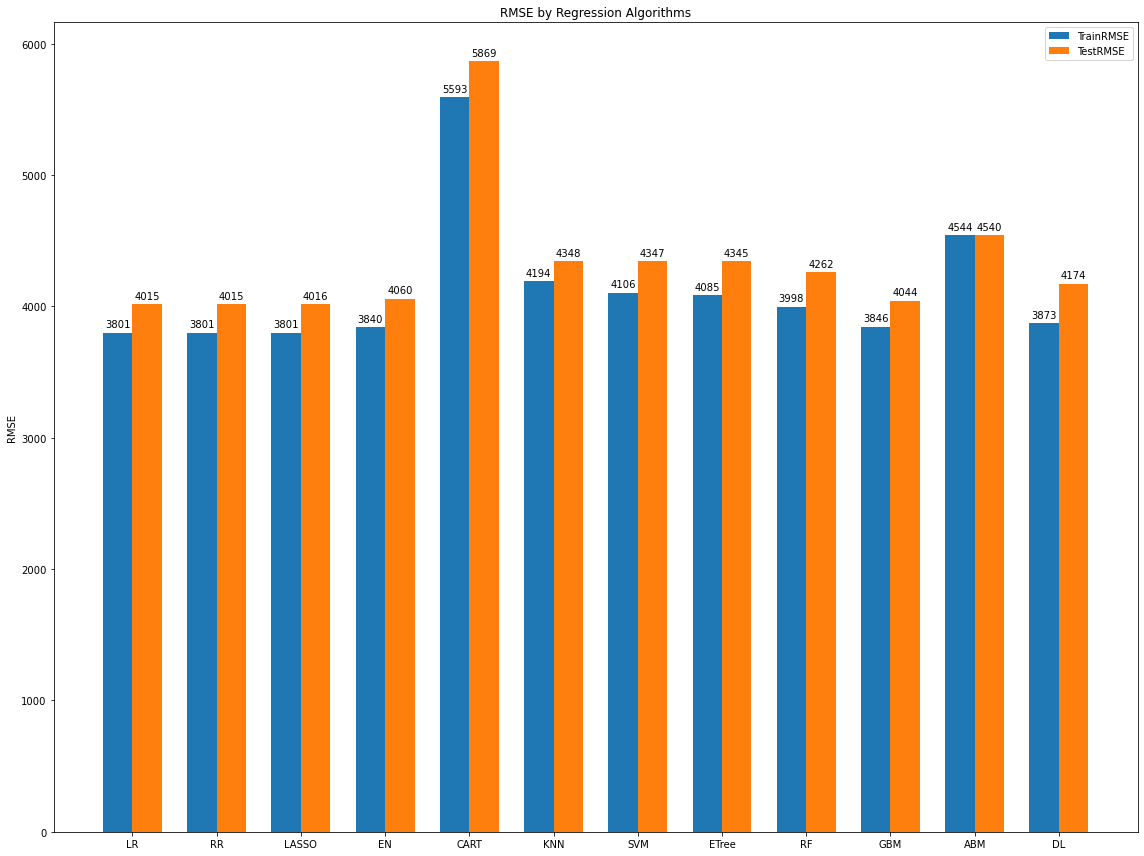

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = names

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

metrics1=[math.floor(item) for item in metrics1]
metrics2=[math.floor(item) for item in metrics2]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics1, width, label='TrainRMSE')
rects2 = ax.bar(x + width/2, metrics2, width, label='TestRMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Regression Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()